# Master1 - Empirical fMRI analyses, exploratory cohort

## Takuya Ito
#### 01/07/2019

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import multiprocessing as mp
import scipy.stats as stats
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.sandbox.stats.multicomp as mc
import sklearn
import seaborn as sns
plt.style.use("ggplot")
sns.set_style('whitegrid')
plt.rcParams["font.family"] = "FreeSans"
import nibabel as nib
import pandas as pd
import sys
sys.path.append('glmScripts/')
import taskGLMPipeline as tgp
import h5py
import dimensionality
sys.path.append('bctpy/')
import bct

## Set-up subject list and construct global variables

In [3]:
## Exploratory subjects
subjNums = ['178950','189450','199453','209228','220721','298455','356948','419239','499566','561444','618952','680452','757764','841349','908860',
            '103818','113922','121618','130619','137229','151829','158035','171633','179346','190031','200008','210112','221319','299154','361234',
            '424939','500222','570243','622236','687163','769064','845458','911849','104416','114217','122317','130720','137532','151930','159744',
            '172029','180230','191235','200614','211316','228434','300618','361941','432332','513130','571144','623844','692964','773257','857263',
            '926862','105014','114419','122822','130821','137633','152427','160123','172938','180432','192035','200917','211417','239944','303119',
            '365343','436239','513736','579665','638049','702133','774663','865363','930449','106521','114823','123521','130922','137936','152831',
            '160729','173334','180533','192136','201111','211619','249947','305830','366042','436845','516742','580650','645450','715041','782561',
            '871762','942658','106824','117021','123925','131823','138332','153025','162026','173536','180735','192439','201414','211821','251833',
            '310621','371843','445543','519950','580751','647858','720337','800941','871964','955465','107018','117122','125222','132017','138837',
            '153227','162329','173637','180937','193239','201818','211922','257542','314225','378857','454140','523032','585862','654350','725751',
            '803240','872562','959574','107422','117324','125424','133827','142828','153631','164030','173940','182739','194140','202719','212015',
            '257845','316633','381543','459453','525541','586460','654754','727553','812746','873968','966975']

## Validation subjects
#subjNums = ['100206','108020','117930','126325','133928','143224','153934','164636','174437','183034','194443','204521','212823','268749','322224',
#             '385450','463040','529953','587664','656253','731140','814548','877269','978578','100408','108222','118124','126426','134021','144832',
#             '154229','164939','175338','185139','194645','204622','213017','268850','329844','389357','467351','530635','588565','657659','737960',
#             '816653','878877','987074','101006','110007','118225','127933','134324','146331','154532','165638','175742','185341','195445','205119',
#             '213421','274542','341834','393247','479762','545345','597869','664757','742549','820745','887373','989987','102311','111009','118831',
#             '128632','135528','146432','154936','167036','176441','186141','196144','205725','213522','285345','342129','394956','480141','552241',
#             '598568','671855','744553','826454','896879','990366','102513','112516','118932','129028','135629','146533','156031','167440','176845',
#             '187850','196346','205826','214423','285446','348545','395756','481042','553344','599671','675661','749058','832651','899885','991267',
#             '102614','112920','119126','129129','135932','147636','157336','168745','177645','188145','198350','208226','214726','286347','349244',
#             '406432','486759','555651','604537','679568','749361','835657','901442','992774','103111','113316','120212','130013','136227','148133',
#             '157437','169545','178748','188549','198451','208327','217429','290136','352738','414229','497865','559457','615744','679770','753150',
#             '837560','907656','993675','103414','113619','120414','130114','136833','150726','157942','171330']

basedir = '/projects3/TaskFCMech/'

# Using final partition
networkdef = np.loadtxt('/projects3/NetworkDiversity/data/network_partition.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[networkorder]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360
nSubjs = len(subjNums)

glasserfile2 = '/projects/AnalysisTools/ParcelsGlasser2016/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser2 = nib.load(glasserfile2).get_data()
glasser2 = np.squeeze(glasser2)

sortednets = np.sort(xticks.keys())
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

tasks = {'EMOTION':[0,1],
     'GAMBLING':[2,3],
     'LANGUAGE':[4,5],
     'MOTOR':[6,7,8,9,10,11],
     'RELATIONAL':[12,13],
     'SOCIAL':[14,15],
     'WM':[16,17,18,19,20,21,22,23]}
taskNames = ['EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WM']
TRsPerRun = [176,176,253,253,316,316,284,284,232,232,274,274,405,405]
restRuns = ['rfMRI_REST1_RL', 'rfMRI_REST1_LR','rfMRI_REST2_RL', 'rfMRI_REST2_LR']
taskRuns= ['tfMRI_EMOTION_RL','tfMRI_EMOTION_LR','tfMRI_GAMBLING_RL','tfMRI_GAMBLING_LR',
           'tfMRI_LANGUAGE_RL','tfMRI_LANGUAGE_LR','tfMRI_MOTOR_RL','tfMRI_MOTOR_LR',
           'tfMRI_RELATIONAL_RL','tfMRI_RELATIONAL_LR','tfMRI_SOCIAL_RL','tfMRI_SOCIAL_LR','tfMRI_WM_RL','tfMRI_WM_LR']

# 0.0 Define functions for loading data

In [4]:
def loadRestResiduals(subj,model='24pXaCompCorXVolterra',zscore=False,FIR=False):
    datafile = '/projects3/TaskFCMech/data/hcppreprocessedmsmall/hcpPostProcCiric/' + subj + '_glmOutput_data.h5' 
    h5f = h5py.File(datafile,'r')
    data = []
    if FIR:
        dataid = 'rfMRI_REST_' + model + '_taskReg_resid_FIR'
        data = h5f['taskRegression'][dataid][:]
        if zscore:
            # Zscore each run separately
            runstart = 0
            for run in range(4):
                runend = runstart + 1195
                data[:,runstart:runend] = stats.zscore(data[:,runstart:runend],axis=1)
                runstart += 1195
                
            # Now z-score rest time series as if it were task
            trcount = 0
            for ntrs in TRsPerRun:
                trstart = trcount
                trend = trcount + ntrs
                data[:,trstart:trend] = stats.zscore(data[:,trstart:trend],axis=1)

                trcount += ntrs

        data = data.T
    else:
        for run in restRuns:
            dataid = run + '/nuisanceReg_resid_' + model
            tmp = h5f[dataid][:]
            tmp = stats.zscore(tmp,axis=1)
            data.extend(tmp.T)
    data = np.asarray(data).T
    h5f.close()
    return data

def loadTaskActivity(subj,model='24pXaCompCorXVolterra',zscore=False):
    datafile = '/projects3/TaskFCMech/data/hcppreprocessedmsmall/hcpPostProcCiric/' + subj + '_glmOutput_data.h5' 
    h5f = h5py.File(datafile,'r')
    betas = []
    for task in taskNames:
        dataid = 'tfMRI_' + task + '_' + model + '_taskReg_betas_canonical'
        tmp = h5f['taskRegression'][dataid][:]
        betas.extend(tmp[:,1:].T)
    betas = np.asarray(betas).T
    h5f.close()
    return betas

def loadTaskResiduals(subj, model='24pXaCompCorXVolterra', taskModel='FIR', zscore=False):
    datafile = '/projects3/TaskFCMech/data/hcppreprocessedmsmall/hcpPostProcCiric/' + subj + '_glmOutput_data.h5'         
    h5f = h5py.File(datafile,'r')
    resids = []
    for task in taskNames:
        dataid = 'tfMRI_' + task + '_' + model + '_taskReg_resid_' + taskModel
        tmp = h5f['taskRegression'][dataid][:]
        if zscore:
            nTRsPerRun = tmp.shape[1]/2
            tmp[:,:nTRsPerRun] = stats.zscore(tmp[:,:nTRsPerRun],axis=1)
            tmp[:,nTRsPerRun:] = stats.zscore(tmp[:,nTRsPerRun:],axis=1)
        resids.extend(tmp.T)
    resids = np.asarray(resids).T
    h5f.close()
    return resids

### Main parameters

In [5]:
model = '24pXaCompCorXVolterra'
zscore = True
FIR = True

# 1.0 Identify number of significantly active regions for each task, relative to 0

## Load rest and task data time series

In [7]:
nTasks = 24
restTS = np.zeros((nParcels,4780,len(subjNums)))
restTS = np.zeros((nParcels,3810,len(subjNums)))
taskTS = np.zeros((nParcels,3810,len(subjNums)))
task_timing = np.zeros((3810,nTasks,len(subjNums)))
scount = 0
for subj in subjNums:
    if scount%25==0: print 'Loading in data for subject', scount+1, '/', len(subjNums)
    restTS[:,:,scount] = loadRestResiduals(subj,model=model,zscore=zscore,FIR=FIR)
    taskTS[:,:,scount] = loadTaskResiduals(subj, model=model, taskModel='FIR', zscore=zscore) # We make this FIR since we only want to use FIR regressed task residuals for FC analysis
    task_timing[:,:,scount] = tgp.loadTaskTimingForAllTasks(subj,taskModel='canonical')['taskRegressors']>.5 # Only to obtain which time points to estimate FC with
    scount += 1
    
task_timing = task_timing.astype(bool)


Loading in data for subject 1 / 176
Loading in data for subject 26 / 176
Loading in data for subject 51 / 176
Loading in data for subject 76 / 176
Loading in data for subject 101 / 176
Loading in data for subject 126 / 176
Loading in data for subject 151 / 176
Loading in data for subject 176 / 176


# Calculate mutual information between all pairs of regions

In [8]:
from sklearn.metrics import mutual_info_score
def calc_MI((x, y, bins)):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi


In [14]:
mi_mat_task = np.zeros((nParcels,nParcels,len(subjNums)))
mi_mat_rest = np.zeros((nParcels,nParcels,len(subjNums)))
df_mi = {}
df_mi['State'] = []
df_mi['Subject'] = []
df_mi['Mutual Information'] = []
bins = 10
nproc = 20
for scount in range(len(subjNums)):
    print('Calc MI FC matrix for subject',scount)
    taskGeneralTiming = np.sum(task_timing[:,:,scount],axis=1)>0
    inputs_rest = []
    inputs_task = []
    for i in range(nParcels):
        for j in range(nParcels):
            if i <= j: continue
            
            inputs_rest.append((restTS[i,taskGeneralTiming,scount],restTS[j,taskGeneralTiming,scount],bins))
            inputs_task.append((taskTS[i,taskGeneralTiming,scount],restTS[j,taskGeneralTiming,scount],bins))
            
    pool = mp.Pool(processes=nproc)
    results_rest = pool.map_async(calc_MI,inputs_rest).get()
    pool.close()
    pool.join()
    
    pool = mp.Pool(processes=nproc)
    results_task = pool.map_async(calc_MI,inputs_task).get()
    pool.close()
    pool.join()
    
    count = 0
    for i in range(nParcels):
        for j in range(nParcels):
            if i<=j: continue
            
            mi_mat_rest[i,j,scount] = results_rest[count] 
            mi_mat_task[i,j,scount] = results_task[count] 
            count += 1
            
    df_mi['State'].append('Rest')
    df_mi['Subject'].append(subjNums[scount])
    df_mi['Mutual Information'].append(np.mean(results_rest))
    
    df_mi['State'].append('Task')
    df_mi['Subject'].append(subjNums[scount])
    df_mi['Mutual Information'].append(np.mean(results_task))
            


('Calc MI FC matrix for subject', 0)
('Calc MI FC matrix for subject', 1)
('Calc MI FC matrix for subject', 2)
('Calc MI FC matrix for subject', 3)
('Calc MI FC matrix for subject', 4)
('Calc MI FC matrix for subject', 5)
('Calc MI FC matrix for subject', 6)
('Calc MI FC matrix for subject', 7)
('Calc MI FC matrix for subject', 8)
('Calc MI FC matrix for subject', 9)
('Calc MI FC matrix for subject', 10)
('Calc MI FC matrix for subject', 11)
('Calc MI FC matrix for subject', 12)
('Calc MI FC matrix for subject', 13)
('Calc MI FC matrix for subject', 14)
('Calc MI FC matrix for subject', 15)
('Calc MI FC matrix for subject', 16)
('Calc MI FC matrix for subject', 17)
('Calc MI FC matrix for subject', 18)
('Calc MI FC matrix for subject', 19)
('Calc MI FC matrix for subject', 20)
('Calc MI FC matrix for subject', 21)
('Calc MI FC matrix for subject', 22)
('Calc MI FC matrix for subject', 23)
('Calc MI FC matrix for subject', 24)
('Calc MI FC matrix for subject', 25)
('Calc MI FC matrix fo

In [15]:
triu_ind = np.tril_indices(nParcels,k=1)
mi_avg_rest = []
mi_avg_task = []
for s in range(len(subjNums)):
    mi_avg_rest.append(np.mean(mi_mat_rest[:,:,s][triu_ind]))
    mi_avg_task.append(np.mean(mi_mat_task[:,:,s][triu_ind]))

In [16]:
t, p = stats.ttest_rel(mi_avg_task,mi_avg_rest)
print 'Average mutual information rest', np.mean(mi_avg_rest)
print 'Average mutual information task', np.mean(mi_avg_task)
print 'task v rest',
print '\tt =', t, '| p =', p

Average mutual information rest 0.03762431312226423
Average mutual information task 0.014840357699997676
task v rest 	t = -29.03138501679776 | p = 8.219208085517866e-69


## Compute average pairwise Mutual Information for task FC and rest FC separately (for each subject)

Task versus rest, global mutual information 	 Dim diff = -0.0230374630662
	 t = -29.031385016797746 | p = $p < 0.0001$


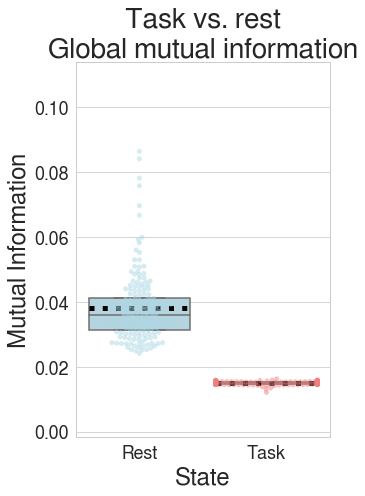

In [17]:
df_mi = pd.DataFrame(df_mi)

# Draw a nested boxplot to show bills by day and time
plt.figure(figsize=(5,7))
tmprest = df_mi.loc[df_mi['State']=='Rest']
tmptask = df_mi.loc[df_mi['State']=='Task']
t, p = stats.ttest_rel(tmptask['Mutual Information'],tmprest['Mutual Information'])

sns.boxplot(data=[tmprest['Mutual Information'],tmptask['Mutual Information']],
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
sns.swarmplot(data=[tmprest['Mutual Information'],tmptask['Mutual Information']],
            palette=["#add8e6","#f08080"],
            alpha=0.5)
if str(round(p,3))=="0.0": 
    p = '$p < 0.0001$'
else:
    p = '$p = ' + str(round(p,3))
plt.title('Task vs. rest\nGlobal mutual information',fontsize=28,fontname='FreeSans')
# plt.title('Task versus Rest\nWhole-brain dimensionality\n$t_{175} = ' + str(round(t,3)) + '$ | ' + p,fontsize=24,fontname='FreeSans')
plt.ylabel('Mutual Information',fontsize=24)
plt.xlabel('State',fontsize=24)
plt.xticks(np.arange(2),['Rest','Task'],fontname='FreeSans',fontsize=18)
plt.ylim([np.min(df_mi['Mutual Information'])-np.std(df_mi['Mutual Information']),np.max(df_mi['Mutual Information'])+2*np.std(df_mi['Mutual Information'])]);
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('fMRI4_GlobalMutualInformation_Exploratory.pdf')

print 'Task versus rest, global mutual information',
print '\t Dim diff =', np.mean(tmptask['Mutual Information']) - np.mean(tmprest['Mutual Information'])
print '\t t =', t, '| p =', p


# Calculate entropy of each region during rest and task

In [79]:
df_entropy = {}
df_entropy['State'] = []
df_entropy['Subject'] = []
df_entropy['Entropy'] = []
entropy_rest_arr = np.zeros((nParcels,len(subjNums)))
entropy_task_arr = np.zeros((nParcels,len(subjNums)))
for scount in range(len(subjNums)):
    print 'Calculating entropy for rest and task states on subject', scount
    tmp_rest = []
    tmp_task = []
    for roi in range(nParcels):
        entropy_rest_arr[roi,scount] = stats.entropy(np.histogram(restTS[roi,taskGeneralTiming,scount])[0])
        entropy_task_arr[roi,scount] = stats.entropy(np.histogram(taskTS[roi,taskGeneralTiming,scount])[0])
        tmp_rest.append(entropy_rest_arr[roi,scount])
        tmp_task.append(entropy_task_arr[roi,scount])
        
    df_entropy['State'].append('Rest')
    df_entropy['Subject'].append(subjNums[scount])
    df_entropy['Entropy'].append(np.mean(tmp_rest))
    
    df_entropy['State'].append('Task')
    df_entropy['Subject'].append(subjNums[scount])
    df_entropy['Entropy'].append(np.mean(tmp_task))

Calculating entropy for rest and task states on subject 0
Calculating entropy for rest and task states on subject 1
Calculating entropy for rest and task states on subject 2
Calculating entropy for rest and task states on subject 3
Calculating entropy for rest and task states on subject 4
Calculating entropy for rest and task states on subject 5
Calculating entropy for rest and task states on subject 6
Calculating entropy for rest and task states on subject 7
Calculating entropy for rest and task states on subject 8
Calculating entropy for rest and task states on subject 9
Calculating entropy for rest and task states on subject 10
Calculating entropy for rest and task states on subject 11
Calculating entropy for rest and task states on subject 12
Calculating entropy for rest and task states on subject 13
Calculating entropy for rest and task states on subject 14
Calculating entropy for rest and task states on subject 15
Calculating entropy for rest and task states on subject 16
Calcula

## Compute average Entropy for task and rest states separately (for each subject)

Average mutual information rest 1.7397353426336983
Average mutual information task 1.7501044757510271
task v rest 	t = 3.7240597770777715 | p = 0.0002641835194971668
Task versus rest, average global entropy 	 Dim diff = 0.0103691331173
	 t = 3.7240597770777715 | p = $p < 0.0001$


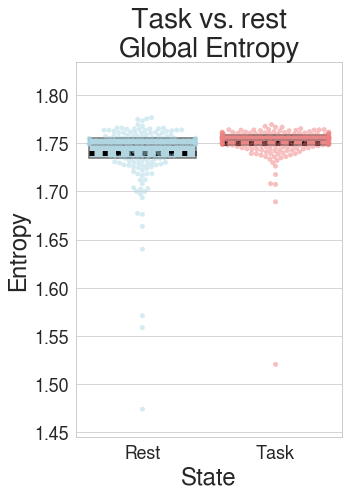

In [54]:
df_entropy = pd.DataFrame(df_entropy)

# Draw a nested boxplot to show bills by day and time
plt.figure(figsize=(5,7))
tmprest = df_entropy.loc[df_entropy['State']=='Rest']
tmptask = df_entropy.loc[df_entropy['State']=='Task']
t, p = stats.ttest_rel(tmptask['Entropy'],tmprest['Entropy'])
print 'Average mutual information rest', np.mean(tmprest.Entropy.values)
print 'Average mutual information task', np.mean(tmptask.Entropy.values)
print 'task v rest',
print '\tt =', t, '| p =', p

sns.boxplot(data=[tmprest['Entropy'],tmptask['Entropy']],
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
sns.swarmplot(data=[tmprest['Entropy'],tmptask['Entropy']],
            palette=["#add8e6","#f08080"],
            alpha=0.5)
if str(round(p,3))=="0.0": 
    p = '$p < 0.0001$'
else:
    p = '$p = ' + str(round(p,3))
plt.title('Task vs. rest\nGlobal Entropy',fontsize=28,fontname='FreeSans')
# plt.title('Task versus Rest\nWhole-brain dimensionality\n$t_{175} = ' + str(round(t,3)) + '$ | ' + p,fontsize=24,fontname='FreeSans')
plt.ylabel('Entropy',fontsize=24)
plt.xlabel('State',fontsize=24)
plt.xticks(np.arange(2),['Rest','Task'],fontname='FreeSans',fontsize=18)
plt.ylim([np.min(df_entropy['Entropy'])-np.std(df_entropy['Entropy']),np.max(df_entropy['Entropy'])+2*np.std(df_entropy['Entropy'])]);
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('fMRI4_GlobalEntropy_Exploratory.pdf')

print 'Task versus rest, average global entropy',
print '\t Dim diff =', np.mean(tmptask['Entropy']) - np.mean(tmprest['Entropy'])
print '\t t =', t, '| p =', p


# Average joint entropy

In [95]:
joint_entropy_rest = np.zeros(mi_mat_rest.shape)
joint_entropy_task = np.zeros(mi_mat_task.shape)
df_jointentropy = {}
df_jointentropy['State'] = []
df_jointentropy['Subject'] = []
df_jointentropy['Joint Entropy'] = []
tril_ind = np.tril_indices(nParcels,k=1)
for s in range(len(subjNums)):
    for i in range(nParcels):
        for j in range(nParcels):
            if i >= j: continue
            joint_entropy_rest[i,j,s] = entropy_rest_arr[i,s] + entropy_rest_arr[j,s] - mi_mat_rest[i,j,s]
            joint_entropy_task[i,j,s] = entropy_task_arr[i,s] + entropy_task_arr[j,s] - mi_mat_task[i,j,s]
                
    df_jointentropy['State'].append('Rest')
    df_jointentropy['Joint Entropy'].append(np.mean(joint_entropy_rest[:,:,s][tril_ind]))
    df_jointentropy['Subject'].append(subjNums[s])
    
    df_jointentropy['State'].append('Task')
    df_jointentropy['Joint Entropy'].append(np.mean(joint_entropy_task[:,:,s][tril_ind]))
    df_jointentropy['Subject'].append(subjNums[s])
            
            

Average joint entropy rest 0.01911780031628564
Average joint entropy task 0.019231392905204366
Task versus rest, average global entropy
	Entropy diff = 0.000113592588919
	 t = 3.712279462984476 | p = 0.00027584251125759


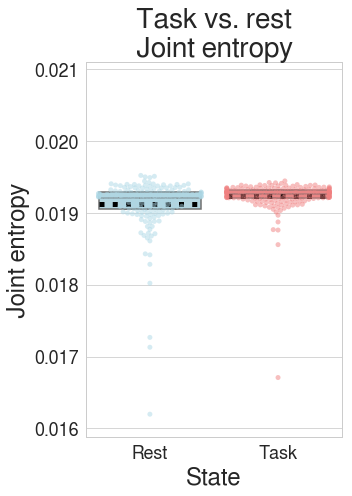

In [104]:
df_jointentropy = pd.DataFrame(df_jointentropy)

# Draw a nested boxplot to show bills by day and time
plt.figure(figsize=(5,7))
tmprest = df_jointentropy.loc[df_jointentropy['State']=='Rest']
tmptask = df_jointentropy.loc[df_jointentropy['State']=='Task']
t, p = stats.ttest_rel(tmptask['Joint Entropy'],tmprest['Joint Entropy'])
print 'Average joint entropy rest', np.mean(tmprest['Joint Entropy'].values)
print 'Average joint entropy task', np.mean(tmptask['Joint Entropy'].values)

sns.boxplot(data=[tmprest['Joint Entropy'],tmptask['Joint Entropy']],
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
sns.swarmplot(data=[tmprest['Joint Entropy'],tmptask['Joint Entropy']],
            palette=["#add8e6","#f08080"],
            alpha=0.5)
plt.title('Task vs. rest\nJoint entropy',fontsize=28,fontname='FreeSans')
# plt.title('Task versus Rest\nWhole-brain dimensionality\n$t_{175} = ' + str(round(t,3)) + '$ | ' + p,fontsize=24,fontname='FreeSans')
plt.ylabel('Joint entropy',fontsize=24)
plt.xlabel('State',fontsize=24)
plt.xticks(np.arange(2),['Rest','Task'],fontname='FreeSans',fontsize=18)
plt.ylim([np.min(df_jointentropy['Joint Entropy'])-np.std(df_jointentropy['Joint Entropy']),np.max(df_jointentropy['Joint Entropy'])+5*np.std(df_jointentropy['Joint Entropy'])]);
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('fMRI4_GlobalJointEntropy_Exploratory.pdf')

print 'Task versus rest, average global entropy'
print '\tEntropy diff =', np.mean(tmptask['Joint Entropy']) - np.mean(tmprest['Joint Entropy'])
print '\t t =', t, '| p =', p


# Calculate kurtosis of each region during rest and task

In [56]:
df_kurtosis = {}
df_kurtosis['State'] = []
df_kurtosis['Subject'] = []
df_kurtosis['Kurtosis'] = []
for scount in range(len(subjNums)):
    print 'Calculating kurtosis for rest and task states on subject', scount
    tmp_rest = []
    tmp_task = []
    for roi in range(nParcels):
        tmp_rest.append(stats.kurtosis(restTS[roi,taskGeneralTiming,scount]))
        tmp_task.append(stats.kurtosis(taskTS[roi,taskGeneralTiming,scount]))
        
    df_kurtosis['State'].append('Rest')
    df_kurtosis['Subject'].append(subjNums[scount])
    df_kurtosis['Kurtosis'].append(np.mean(tmp_rest))
    
    df_kurtosis['State'].append('Task')
    df_kurtosis['Subject'].append(subjNums[scount])
    df_kurtosis['Kurtosis'].append(np.mean(tmp_task))

Calculating kurtosis for rest and task states on subject 0
Calculating kurtosis for rest and task states on subject 1
Calculating kurtosis for rest and task states on subject 2
Calculating kurtosis for rest and task states on subject 3
Calculating kurtosis for rest and task states on subject 4
Calculating kurtosis for rest and task states on subject 5
Calculating kurtosis for rest and task states on subject 6
Calculating kurtosis for rest and task states on subject 7
Calculating kurtosis for rest and task states on subject 8
Calculating kurtosis for rest and task states on subject 9
Calculating kurtosis for rest and task states on subject 10
Calculating kurtosis for rest and task states on subject 11
Calculating kurtosis for rest and task states on subject 12
Calculating kurtosis for rest and task states on subject 13
Calculating kurtosis for rest and task states on subject 14
Calculating kurtosis for rest and task states on subject 15
Calculating kurtosis for rest and task states on s

## Plot kurtosis for task and rest states separately (for each subject)

Average mutual information rest 0.17404733653946303
Average mutual information task 0.1568782202272263
task v rest 	t = -2.45205521814174 | p = 0.015185877809588902
Task versus rest, average global kurtosis 	 Dim diff = -0.0171691163122
	 t = -2.45205521814174 | p = $p = 0.015


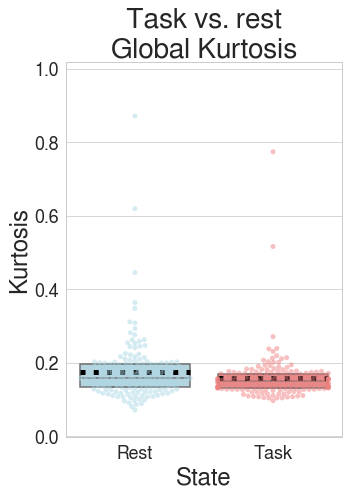

In [58]:
df_kurtosis = pd.DataFrame(df_kurtosis)

# Draw a nested boxplot to show bills by day and time
plt.figure(figsize=(5,7))
tmprest = df_kurtosis.loc[df_kurtosis['State']=='Rest']
tmptask = df_kurtosis.loc[df_kurtosis['State']=='Task']
t, p = stats.ttest_rel(tmptask['Kurtosis'],tmprest['Kurtosis'])
print 'Average mutual information rest', np.mean(tmprest.Kurtosis.values)
print 'Average mutual information task', np.mean(tmptask.Kurtosis.values)
print 'task v rest',
print '\tt =', t, '| p =', p

sns.boxplot(data=[tmprest['Kurtosis'],tmptask['Kurtosis']],
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
sns.swarmplot(data=[tmprest['Kurtosis'],tmptask['Kurtosis']],
            palette=["#add8e6","#f08080"],
            alpha=0.5)
if str(round(p,3))=="0.0": 
    p = '$p < 0.0001$'
else:
    p = '$p = ' + str(round(p,3))
plt.title('Task vs. rest\nGlobal Kurtosis',fontsize=28,fontname='FreeSans')
# plt.title('Task versus Rest\nWhole-brain dimensionality\n$t_{175} = ' + str(round(t,3)) + '$ | ' + p,fontsize=24,fontname='FreeSans')
plt.ylabel('Kurtosis',fontsize=24)
plt.xlabel('State',fontsize=24)
plt.xticks(np.arange(2),['Rest','Task'],fontname='FreeSans',fontsize=18)
plt.ylim([np.min(df_kurtosis['Kurtosis'])-np.std(df_kurtosis['Kurtosis']),np.max(df_kurtosis['Kurtosis'])+2*np.std(df_kurtosis['Kurtosis'])]);
plt.yticks(fontsize=18)
plt.tight_layout()
# plt.savefig('fMRI4_GlobalKurtosis_Exploratory.pdf')

print 'Task versus rest, average global kurtosis',
print '\t Dim diff =', np.mean(tmptask['Kurtosis']) - np.mean(tmprest['Kurtosis'])
print '\t t =', t, '| p =', p
